In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mohammedtawfikmusaed_asthma_detection_dataset_version_2_path = kagglehub.dataset_download('mohammedtawfikmusaed/asthma-detection-dataset-version-2')

print('Data source import complete.')


100%|██████████| 322M/322M [00:15<00:00, 22.0MB/s]

Extracting files...


Data source import complete.


# Import

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
# from IPython.display import Audio

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from sklearn.metrics import confusion_matrix, classification_report

# Data Load & Visualization

In [3]:
print(mohammedtawfikmusaed_asthma_detection_dataset_version_2_path)


/root/.cache/kagglehub/datasets/mohammedtawfikmusaed/asthma-detection-dataset-version-2/versions/1


In [4]:
import os
import pandas as pd

# Correct kagglehub dataset base path
base_path = "/root/.cache/kagglehub/datasets/mohammedtawfikmusaed/asthma-detection-dataset-version-2/versions/1"

# Explore once (optional, but safe)
print(os.listdir(base_path))

# Update this if needed after checking folder names
directory = os.path.join(
    base_path,
    "Asthma Detection Dataset Version 2",
    "Asthma Detection Dataset Version 2"
)

# Verify directory exists
assert os.path.exists(directory), "Directory path is incorrect!"

# Build dataframe
filepath = []
label = []

for class_name in os.listdir(directory):
    class_path = os.path.join(directory, class_name)

    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)

            if file.lower().endswith((".wav", ".mp3")):  # audio safety check
                filepath.append(file_path)
                label.append(class_name)

df = pd.DataFrame({
    "filepath": filepath,
    "label": label
})

df.head()


['Des.txt', 'Asthma Detection Dataset Version 2']


,filepath,label
0,/root/.cache/kagglehub/datasets/mohammedtawfik...,pneumonia
1,/root/.cache/kagglehub/datasets/mohammedtawfik...,pneumonia
2,/root/.cache/kagglehub/datasets/mohammedtawfik...,pneumonia
3,/root/.cache/kagglehub/datasets/mohammedtawfik...,pneumonia
4,/root/.cache/kagglehub/datasets/mohammedtawfik...,pneumonia


In [5]:
import os
import librosa

# Correct base path (kagglehub)
BASE_PATH = "/root/.cache/kagglehub/datasets/mohammedtawfikmusaed/asthma-detection-dataset-version-2/versions/1/Asthma Detection Dataset Version 2/Asthma Detection Dataset Version 2"

def check_audio(filepath):
    if not os.path.exists(filepath):
        return False

    try:
        data, sample_rate = librosa.load(
            filepath,
            sr=22050,
            duration=2.5,
            offset=0.6,
            mono=True
        )
        return len(data) > 0

    except Exception as e:
        return False


In [6]:
df['good'] = df['filepath'].apply(check_audio)
df = df[df.good]
df = df.reset_index()
df = df.drop('good', axis=1)
df

/tmp/ipython-input-2913964807.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sample_rate = librosa.load(
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


,index,filepath,label
0,0,/root/.cache/kagglehub/datasets/mohammedtawfik...,pneumonia
1,1,/root/.cache/kagglehub/datasets/mohammedtawfik...,pneumonia
2,2,/root/.cache/kagglehub/datasets/mohammedtawfik...,pneumonia
3,3,/root/.cache/kagglehub/datasets/mohammedtawfik...,pneumonia
4,4,/root/.cache/kagglehub/datasets/mohammedtawfik...,pneumonia
...,...,...,...
1204,1206,/root/.cache/kagglehub/datasets/mohammedtawfik...,copd
1205,1207,/root/.cache/kagglehub/datasets/mohammedtawfik...,copd
1206,1208,/root/.cache/kagglehub/datasets/mohammedtawfik...,copd
1207,1209,/root/.cache/kagglehub/datasets/mohammedtawfik...,copd


In [7]:
label_classes = ['Bronchial', 'asthma', 'copd', 'healthy', 'pneumonia']

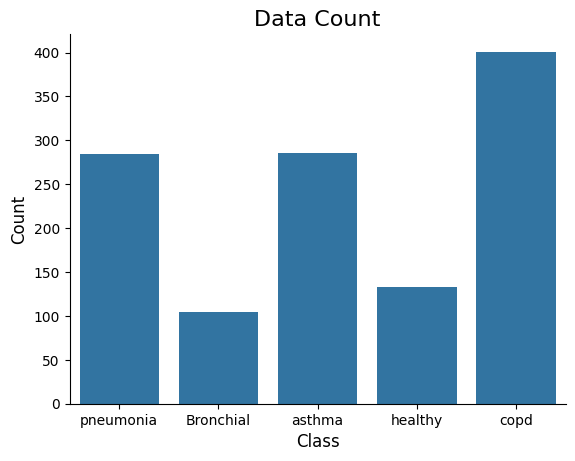

In [8]:
plt.title('Data Count', size=16)
sns.countplot(x='label', data=df)
plt.ylabel('Count', size=12)
plt.xlabel('Class', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [9]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {}'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {}'.format(e), size=15)
#     librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

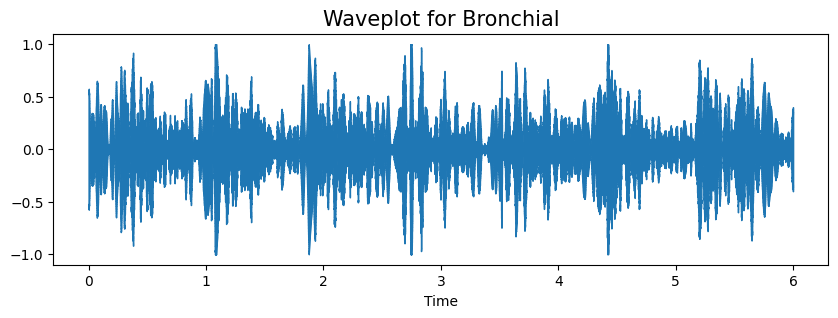

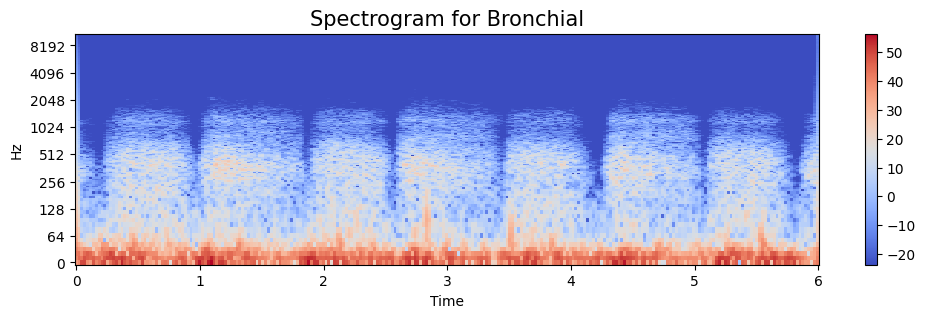

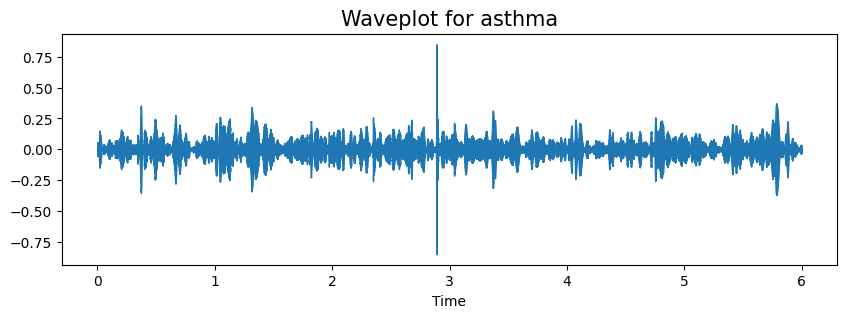

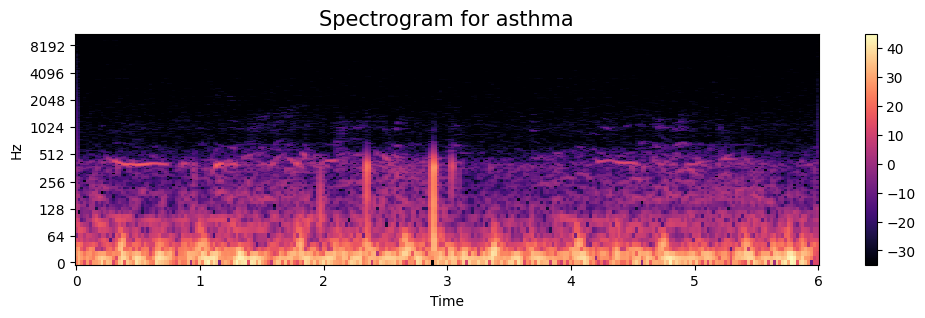

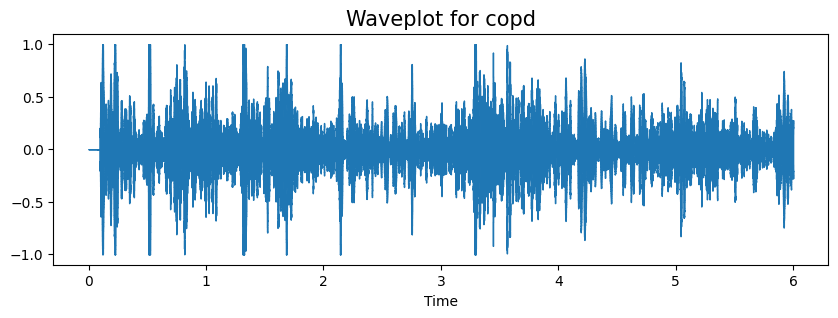

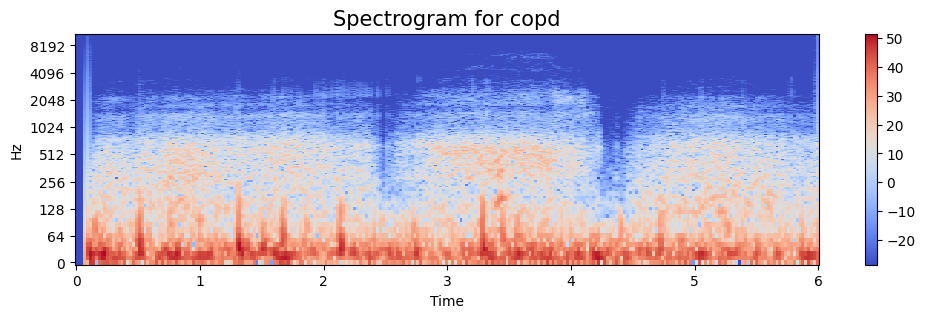

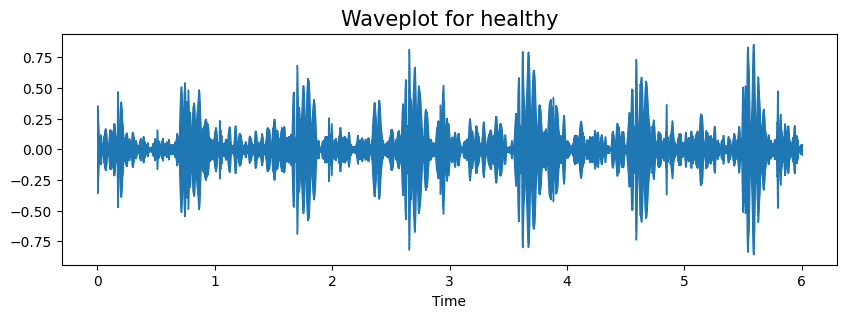

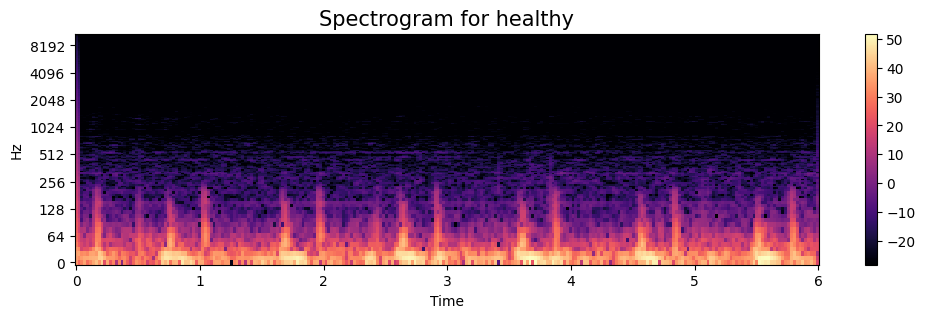

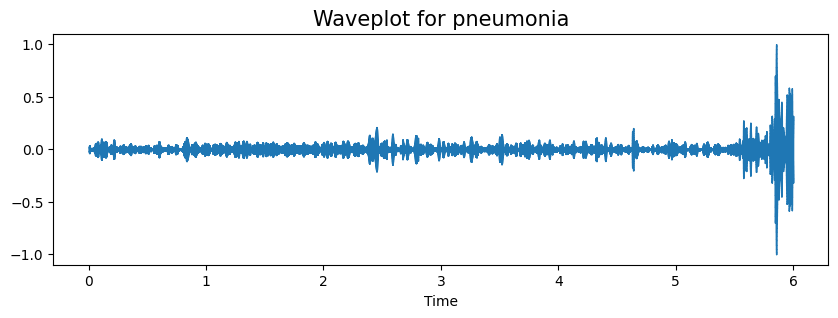

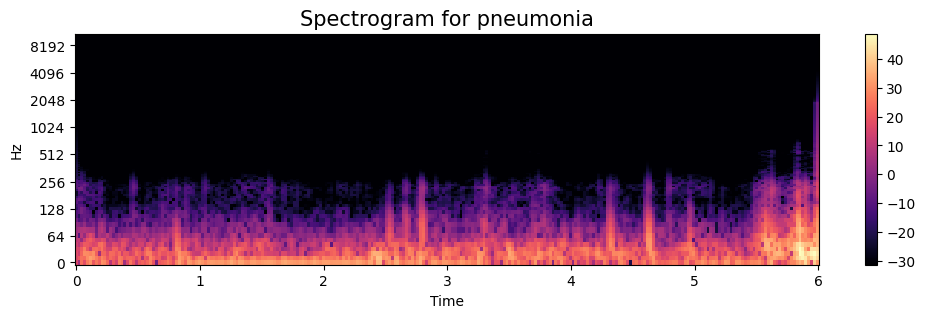

In [10]:
for name in label_classes:
    label = name
    path = np.array(df.filepath[df.label==label])[0]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, label)
    create_spectrogram(data, sampling_rate, label)
#     Audio(path)

# Feature Extraction

In [11]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

In [12]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

In [13]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    return result

def get_aug_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.array(res2)

    # data with stretching and pitching
    stretch_data = stretch(data)
    data_stretch_pitch = pitch(stretch_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [14]:
def get_df_features(dataframe, augmentation=False):
    X, Y = [], []
    processed = 0
    total = len(dataframe.filepath)
    for filepath, label in zip(dataframe.filepath, dataframe.label):
        if augmentation:
            feature = get_aug_features(filepath)
            for aug in feature:
                X.append(aug)
                Y.append(label)
        else:
            feature = get_features(filepath)
            X.append(feature)
            Y.append(label)
        processed += 1
        print('Processed:', processed, '/', total, end="\r")
    return X, Y

In [15]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=49, shuffle=True)
df_train.shape, df_test.shape

((967, 3), (242, 3))

In [16]:
x_train, y_train = get_df_features(df_train)
print('Train data processed')
x_train_aug, y_train_aug = get_df_features(df_train, augmentation=True)
print('Train data augmentation processed')
x_train.extend(x_train_aug)
y_train.extend(y_train_aug)

x_test, y_test = get_df_features(df_test)
print('Test data processed')

/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1235
  warnings.warn(


Train data processed


/usr/local/lib/python3.12/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1235
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1544
  warnings.warn(


Train data augmentation processed
Test data processed


In [17]:
features_train = pd.DataFrame(x_train)
features_train['label'] = y_train
features_train.to_csv('features_train.csv', index=False)
features_train

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,label
0,0.002166,0.703563,0.711234,0.744150,0.770058,0.787985,0.829813,0.833280,0.767979,0.713195,...,3.870933e-05,3.366901e-05,3.073748e-05,3.120202e-05,3.101877e-05,2.836781e-05,2.708150e-05,2.011751e-05,6.638270e-06,pneumonia
1,0.003884,0.752405,0.758986,0.784380,0.821207,0.856860,0.922083,0.930012,0.841556,0.773968,...,4.422091e-06,4.846923e-06,5.178209e-06,5.012353e-06,4.201341e-06,3.176118e-06,2.320881e-06,1.229295e-06,1.575323e-07,copd
2,0.001881,0.873851,0.866916,0.808193,0.777368,0.786576,0.789326,0.784444,0.828098,0.870204,...,1.833533e-07,1.788761e-07,1.751171e-07,1.717245e-07,1.687644e-07,1.663879e-07,1.644376e-07,1.630939e-07,1.621807e-07,asthma
3,0.001112,0.818104,0.761002,0.771737,0.785785,0.822109,0.874296,0.821930,0.868606,0.898576,...,7.414410e-05,7.238014e-05,7.089980e-05,6.956153e-05,6.839234e-05,6.745361e-05,6.668222e-05,6.615129e-05,6.578941e-05,copd
4,0.002993,0.828518,0.886951,0.891176,0.848004,0.809502,0.792419,0.752031,0.753425,0.754279,...,9.140650e-07,8.922735e-07,8.739912e-07,8.574598e-07,8.430205e-07,8.314245e-07,8.218997e-07,8.153418e-07,8.108740e-07,asthma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2896,0.003053,0.796164,0.774041,0.835230,0.849955,0.821549,0.838403,0.784080,0.768318,0.747699,...,8.151087e-06,7.615335e-06,7.034752e-06,8.457855e-06,7.803435e-06,7.613460e-06,6.634368e-06,3.919818e-06,3.738789e-07,copd
2897,0.019748,0.905386,0.922701,0.889577,0.885255,0.893720,0.822107,0.791975,0.823576,0.868445,...,6.925979e-04,7.043703e-04,7.041200e-04,6.838773e-04,6.898004e-04,6.916494e-04,6.716436e-04,7.270805e-04,7.087949e-04,asthma
2898,0.002995,0.780003,0.812328,0.749429,0.716064,0.721559,0.693487,0.722145,0.788619,0.828781,...,1.352430e-05,1.311057e-05,1.277728e-05,1.247468e-05,1.221177e-05,1.203645e-05,1.198683e-05,9.767107e-06,3.990154e-06,asthma
2899,0.049583,0.913795,0.927202,0.938696,0.950073,0.935736,0.819558,0.792479,0.803620,0.828753,...,4.750674e-03,4.749004e-03,4.926865e-03,4.592488e-03,4.878092e-03,4.918733e-03,4.559056e-03,4.692824e-03,4.795150e-03,asthma


In [18]:
features_test = pd.DataFrame(x_test)
features_test['label'] = y_test
features_test.to_csv('features_test.csv', index=False)
features_test

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,label
0,0.001772,0.842891,0.840295,0.872738,0.909464,0.936898,0.918518,0.842540,0.813119,0.810015,...,3.918178e-07,3.824899e-07,3.746617e-07,3.675866e-07,3.614030e-07,3.564398e-07,3.523611e-07,3.495532e-07,3.476404e-07,asthma
1,0.004914,0.782446,0.804723,0.868906,0.859512,0.818893,0.787987,0.791767,0.827917,0.891202,...,1.472536e-05,1.504677e-05,1.489229e-05,1.430473e-05,1.491399e-05,1.580666e-05,1.606948e-05,1.168049e-05,5.728621e-06,copd
2,0.000791,0.798226,0.770548,0.783646,0.805486,0.843121,0.863693,0.843146,0.881223,0.907424,...,3.286432e-06,3.207339e-06,3.140944e-06,3.080970e-06,3.028601e-06,2.986563e-06,2.952027e-06,2.928252e-06,2.912065e-06,copd
3,0.002731,0.801115,0.792870,0.820819,0.854402,0.854648,0.848745,0.831596,0.839649,0.818517,...,3.078632e-05,3.202997e-05,3.316341e-05,3.225771e-05,3.112095e-05,3.047624e-05,2.832180e-05,2.211262e-05,1.020391e-05,copd
4,0.002044,0.887540,0.916292,0.800498,0.720232,0.700625,0.694892,0.700111,0.762788,0.833999,...,1.505687e-08,1.469844e-08,1.439765e-08,1.412574e-08,1.388816e-08,1.369739e-08,1.354068e-08,1.343279e-08,1.335930e-08,asthma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.001555,0.776335,0.791228,0.822637,0.863052,0.928160,0.898965,0.852255,0.838614,0.800972,...,3.611488e-05,3.354212e-05,3.140079e-05,2.941041e-05,2.656864e-05,2.533558e-05,2.586366e-05,1.964368e-05,7.088840e-06,healthy
238,0.005407,0.818351,0.837778,0.885976,0.854509,0.840643,0.799752,0.742814,0.730709,0.757757,...,6.897401e-07,6.996860e-07,6.815205e-07,6.846990e-07,6.494706e-07,6.309647e-07,6.512852e-07,4.422683e-07,1.153001e-07,healthy
239,0.005923,0.716052,0.777125,0.840085,0.835449,0.735616,0.650608,0.581701,0.557118,0.564978,...,1.198856e-07,1.169783e-07,1.145382e-07,1.123347e-07,1.104116e-07,1.088671e-07,1.075996e-07,1.067263e-07,1.061322e-07,copd
240,0.001795,0.886599,0.914612,0.919674,0.890406,0.858469,0.830057,0.785510,0.791666,0.801008,...,5.412544e-08,5.283660e-08,5.175511e-08,5.077737e-08,4.992310e-08,4.923723e-08,4.867377e-08,4.828573e-08,4.802152e-08,asthma


# Classification

## Support Vector Machine

In [19]:
x_train_svm = features_train.iloc[: ,:-1].values
y_train_svm = features_train['label'].values

x_test_svm = features_test.iloc[: ,:-1].values
y_test_svm = features_test['label'].values

x_train_svm.shape, y_train_svm.shape, x_test_svm.shape, y_test_svm.shape

((2901, 162), (2901,), (242, 162), (242,))

In [20]:
scaler = StandardScaler()
x_train_svm = scaler.fit_transform(x_train_svm)
x_test_svm = scaler.transform(x_test_svm)

In [21]:
model_svm = svm.SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
model_svm.fit(x_train_svm, y_train_svm)

SVC(probability=True)

In [22]:
y_pred_svm = model_svm.predict(x_test_svm)

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

   Bronchial       0.94      0.59      0.73        27
      asthma       0.65      0.87      0.74        53
        copd       0.91      0.82      0.86        76
     healthy       0.77      0.61      0.68        28
   pneumonia       0.72      0.79      0.75        58

    accuracy                           0.77       242
   macro avg       0.80      0.74      0.75       242
weighted avg       0.79      0.77      0.77       242



In [23]:
svm_predictions = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
svm_predictions['Predicted Labels'] = y_pred_svm.flatten()
svm_predictions['Actual Labels'] = y_test_svm.flatten()

svm_predictions.head(10)

,Predicted Labels,Actual Labels
0,asthma,asthma
1,copd,copd
2,copd,copd
3,pneumonia,copd
4,asthma,asthma
5,copd,copd
6,asthma,Bronchial
7,copd,copd
8,asthma,Bronchial
9,asthma,asthma


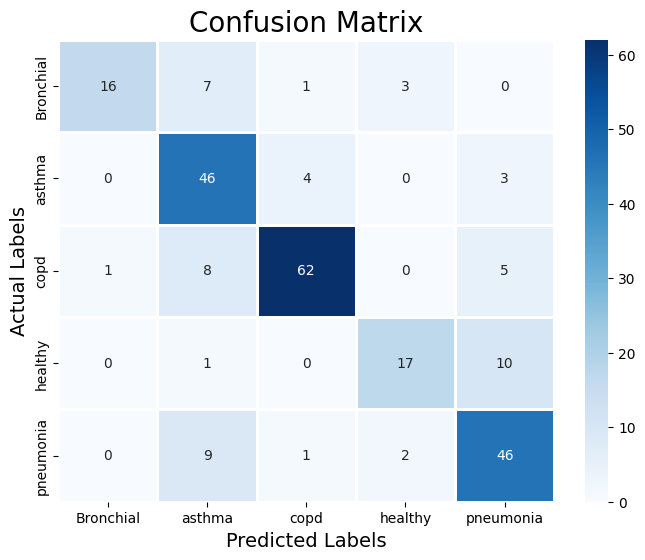

In [24]:
cm = confusion_matrix(y_test_svm, y_pred_svm)
plt.figure(figsize = (8, 6))
cm = pd.DataFrame(cm, index = label_classes , columns = label_classes)
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

## Deep Neural Network

In [25]:
x_train = features_train.iloc[: ,:-1].values
y_train = features_train['label'].values

x_test = features_test.iloc[: ,:-1].values
y_test = features_test['label'].values

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2901, 162), (2901,), (242, 162), (242,))

In [26]:
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()

encoder = OneHotEncoder()
y_test = encoder.fit_transform(np.array(y_test).reshape(-1,1)).toarray()

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2901, 162), (2901, 5), (242, 162), (242, 5))

In [27]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2901, 162, 1), (2901, 5), (242, 162, 1), (242, 5))

In [28]:
input_shape = (x_train.shape[1], 1)
inputs = Input(shape=input_shape)

x = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)

x = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)

x = Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)

x = Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=5, strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

outputs = Dense(len(label_classes), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 162, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 162, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 81, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 41, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        22,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,133 (2.14 MB)

 Trainable params: 558,661 (2.13 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [29]:
start_lr = 0.000001
min_lr = 0.000001
max_lr = 0.0001
rampup_epochs = 9
sustain_epochs = 5
exp_decay = 0.9

def schedule(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr) / rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay ** (epoch - rampup_epochs - sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)

lr_scheduler = LearningRateScheduler(schedule, verbose=False)
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, start_from_epoch=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', min_delta=1e-3, factor=0.4, verbose=False, patience=2, min_lr=1e-6)

In [30]:
epochs = 100
history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stop, lr_scheduler])

Epoch 1/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 17s 81ms/step - accuracy: 0.1971 - loss: 2.3552 - val_accuracy: 0.2273 - val_loss: 2.1831 - learning_rate: 1.0000e-06
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2774 - loss: 1.9567 - val_accuracy: 0.2603 - val_loss: 1.7848 - learning_rate: 1.2000e-05
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3824 - loss: 1.6581 - val_accuracy: 0.4008 - val_loss: 1.5048 - learning_rate: 2.3000e-05
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4568 - loss: 1.4789 - val_accuracy: 0.4298 - val_loss: 1.4542 - learning_rate: 3.4000e-05
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5244 - loss: 1.3259 - val_accuracy: 0.4917 - val_loss: 1.4525 - learning_rate: 4.5000e-05
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5383 - loss: 1.2966 - val_accuracy: 0.4587 - val_loss: 1.3608 - learning_rate: 5.6000e-05
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.549

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7158 - loss: 0.8102 
Accuracy on test data : 74.38016533851624 %


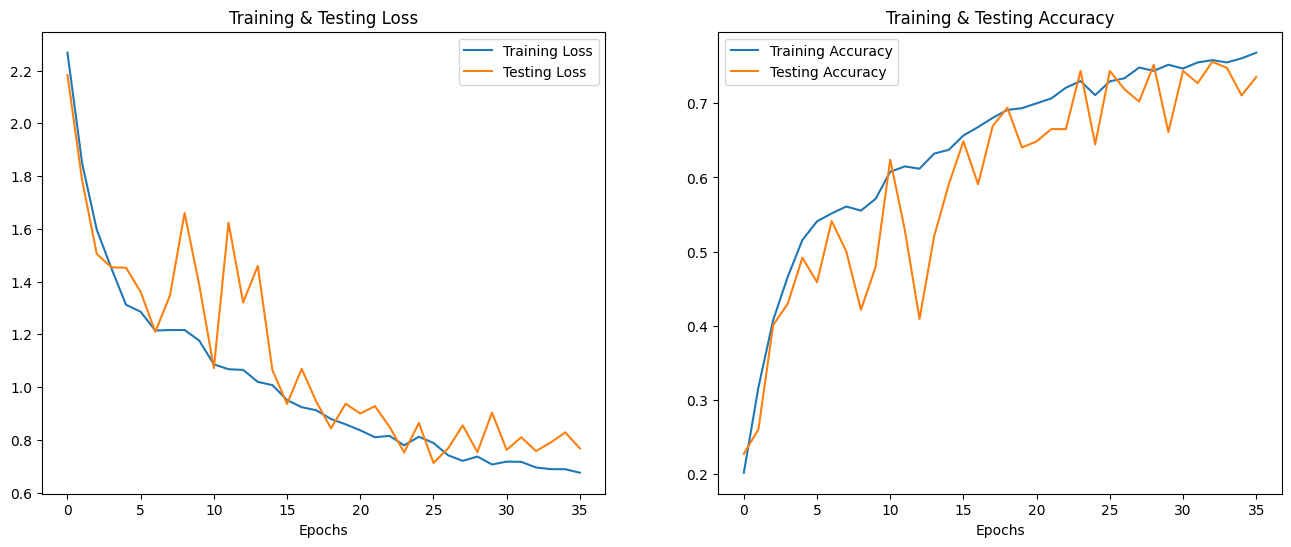

In [31]:
print("Accuracy on test data :" , model.evaluate(x_test,y_test)[1]*100 , "%")

num_epochs = len(history.history['loss'])
epoch = [i for i in range(num_epochs)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(16,6)
ax[0].plot(epoch , train_loss , label = 'Training Loss')
ax[0].plot(epoch , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epoch , train_acc , label = 'Training Accuracy')
ax[1].plot(epoch , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [32]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_true = encoder.inverse_transform(y_test)

print(classification_report(y_true, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step
              precision    recall  f1-score   support

   Bronchial       0.94      0.59      0.73        27
      asthma       0.65      0.85      0.74        53
        copd       0.82      0.84      0.83        76
     healthy       0.63      0.43      0.51        28
   pneumonia       0.73      0.74      0.74        58

    accuracy                           0.74       242
   macro avg       0.75      0.69      0.71       242
weighted avg       0.75      0.74      0.74       242



In [33]:
predictions = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
predictions['Predicted Labels'] = y_pred.flatten()
predictions['Actual Labels'] = y_true.flatten()

predictions.head(10)

,Predicted Labels,Actual Labels
0,asthma,asthma
1,copd,copd
2,copd,copd
3,asthma,copd
4,asthma,asthma
5,copd,copd
6,asthma,Bronchial
7,copd,copd
8,asthma,Bronchial
9,asthma,asthma


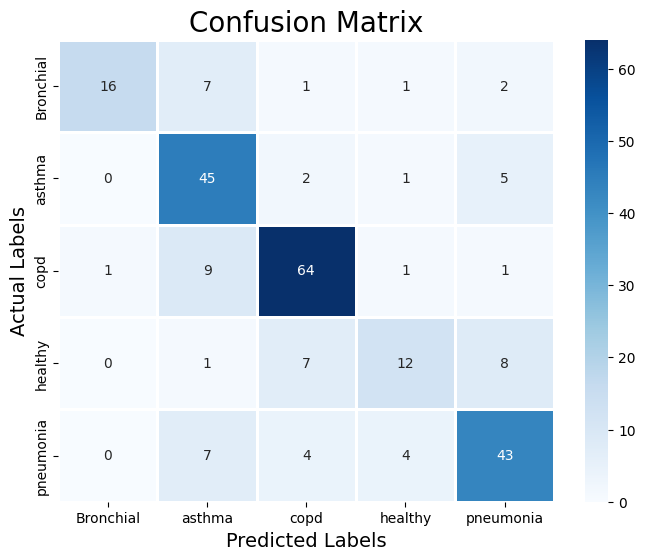

In [34]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (8, 6))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [35]:
import joblib
joblib.dump(model_svm, "svm_asthma_model.pkl")
joblib.dump(scaler, "svm_scaler.pkl")


['svm_scaler.pkl']

In [36]:
model.save("cnn_respiratory_model.h5")


In [37]:
import numpy as np
import librosa
import joblib
from tensorflow.keras.models import load_model


In [38]:
def extract_features(data):
    result = np.array([])

    zcr = np.mean(librosa.feature.zero_crossing_rate(data).T, axis=0)
    result = np.hstack((result, zcr))

    stft = np.abs(librosa.stft(data))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft).T, axis=0)
    result = np.hstack((result, chroma))

    mfcc = np.mean(librosa.feature.mfcc(y=data).T, axis=0)
    result = np.hstack((result, mfcc))

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    mel = np.mean(librosa.feature.melspectrogram(y=data).T, axis=0)
    result = np.hstack((result, mel))

    return result


In [39]:
def preprocess_audio(audio_path):
    data, sr = librosa.load(audio_path, duration=2.5, offset=0.6)
    features = extract_features(data)
    return features.reshape(1, -1)


In [40]:
cnn_model = load_model("cnn_respiratory_model.h5")

def predict_disease_cnn(audio_path):
    features = preprocess_audio(audio_path)
    features = np.expand_dims(features, axis=2)

    probs = cnn_model.predict(features)
    class_idx = np.argmax(probs)
    confidence = np.max(probs)

    return label_classes[class_idx], confidence


In [61]:
import random
import os

BASE_PATH = "/root/.cache/kagglehub/datasets/mohammedtawfikmusaed/asthma-detection-dataset-version-2/versions/1/Asthma Detection Dataset Version 2/Asthma Detection Dataset Version 2"

# Pick random class
random_class = random.choice(os.listdir(BASE_PATH))

# Pick random audio from that class
audio_file = random.choice(os.listdir(os.path.join(BASE_PATH, random_class)))

audio_path = os.path.join(BASE_PATH, random_class, audio_file)

print("Testing audio:", audio_path)

pred, conf = predict_disease_cnn(audio_path)

print(f"Predicted Disease: {pred}")
print(f"Confidence: {conf*100:.2f}%")


Testing audio: /root/.cache/kagglehub/datasets/mohammedtawfikmusaed/asthma-detection-dataset-version-2/versions/1/Asthma Detection Dataset Version 2/Asthma Detection Dataset Version 2/pneumonia/P42Pneumonia47W.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Disease: asthma
Confidence: 84.16%
